### ДЗ 
Используя RandomForestClassifier и еще 2 метода МО предсказать будущий ABC класс на основе любых фичей

Найти причину/фактор низкой маржинальности

In [86]:
import pandas as pd

In [87]:
df = pd.read_excel('DataSet_w_NA.xlsx', sheet_name="Испорченные факты")

In [88]:
df.head()

,Номер заказа,Возврат,Дата заказа,Дата отправки,Режим отправки,Факты.Контрагент ID,Факты.Товар ID,"Продажи, руб","Продажи, шт",Скидка,Маржинальная прибыль,Повторение заказа,Повторение контрагента,Повторение товара
0,2014-100279,Нет,2015-09-10 00:00:00,2015-09-14 00:00:00,Стандарт,CLNT0000422,PROD0000870,11190.0,2.0,0.0,5371.20,1,7,3
1,2014-100293,Нет,2015-09-14 00:00:00,2015-09-18 00:00:00,Стандарт,CLNT0000784,PROD0000646,45528.0,6.0,0.2,15934.80,1,4,8
2,2014-100328,Нет,2015-07-28 00:00:00,2015-08-03 00:00:00,Стандарт,CLNT0000342,PROD0000187,1964.0,1.0,0.2,662.85,1,4,12
3,2014-100363,Нет,2015-10-08 00:00:00,2015-10-15 00:00:00,Стандарт,CLNT0000146,PROD0001095,1184.0,2.0,0.2,414.40,2,12,7
4,2014-100363,Нет,2015-10-08 00:00:00,2015-10-15 00:00:00,Стандарт,CLNT0000146,PROD0001616,9504.0,3.0,0.2,3445.20,2,12,3


In [89]:
df.shape

(10293, 14)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10293 entries, 0 to 10292
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Номер заказа            10293 non-null  object 
 1   Возврат                 10293 non-null  object 
 2   Дата заказа             10293 non-null  object 
 3   Дата отправки           10293 non-null  object 
 4   Режим отправки          10293 non-null  object 
 5   Факты.Контрагент ID     10203 non-null  object 
 6   Факты.Товар ID          10242 non-null  object 
 7   Продажи, руб            10098 non-null  float64
 8   Продажи, шт             10272 non-null  float64
 9   Скидка                  10293 non-null  float64
 10  Маржинальная прибыль    10275 non-null  float64
 11  Повторение заказа       10293 non-null  int64  
 12  Повторение контрагента  10293 non-null  int64  
 13  Повторение товара       10293 non-null  int64  
dtypes: float64(4), int64(3), object(7)
mem

Посмотрим на наличие Nan значений

In [91]:
df.isna().sum()

Номер заказа                0
Возврат                     0
Дата заказа                 0
Дата отправки               0
Режим отправки              0
Факты.Контрагент ID        90
Факты.Товар ID             51
Продажи, руб              195
Продажи, шт                21
Скидка                      0
Маржинальная прибыль       18
Повторение заказа           0
Повторение контрагента      0
Повторение товара           0
dtype: int64

С учетом того, что NaN значений гораздо меньше, чем число строк в датасете, можно просто убрать такие строки

In [92]:
df = df.dropna()

In [93]:
df.shape

(9993, 14)

In [94]:
df = df.groupby(['Факты.Товар ID'], as_index=False) \
    .agg('sum')
df

,Факты.Товар ID,"Продажи, руб","Продажи, шт",Скидка,Маржинальная прибыль,Повторение заказа,Повторение контрагента,Повторение товара
0,PROD0000001,631978.5,12.0,0.85,-28160.70,6,77,16
1,PROD0000002,5318764.0,51.0,1.70,963721.00,32,163,144
2,PROD0000003,76755.0,23.0,0.60,32200.55,18,104,49
3,PROD0000004,3621384.0,29.0,2.10,-266380.65,17,132,64
4,PROD0000005,150984.0,24.0,0.60,31874.40,18,88,25
...,...,...,...,...,...,...,...,...
1857,PROD0001890,161988.0,3.0,0.20,18223.65,3,13,1
1858,PROD0001891,112468.5,3.0,0.70,-82476.90,6,6,1
1859,PROD0001892,98860.0,4.0,0.00,27680.80,1,9,1
1860,PROD0001893,749985.0,5.0,0.40,-187496.25,2,20,1


In [95]:
all_sales = df['Продажи, шт'].sum()
all_sales_money = df['Продажи, руб'].sum()

df['Доля продаж, шт'] = df['Продажи, шт']/all_sales*100
df['Доля продаж, руб'] = df['Продажи, руб']/all_sales_money*100
df

,Факты.Товар ID,"Продажи, руб","Продажи, шт",Скидка,Маржинальная прибыль,Повторение заказа,Повторение контрагента,Повторение товара,"Доля продаж, шт","Доля продаж, руб"
0,PROD0000001,631978.5,12.0,0.85,-28160.70,6,77,16,0.031687,0.055028
1,PROD0000002,5318764.0,51.0,1.70,963721.00,32,163,144,0.134668,0.463122
2,PROD0000003,76755.0,23.0,0.60,32200.55,18,104,49,0.060732,0.006683
3,PROD0000004,3621384.0,29.0,2.10,-266380.65,17,132,64,0.076576,0.315325
4,PROD0000005,150984.0,24.0,0.60,31874.40,18,88,25,0.063373,0.013147
...,...,...,...,...,...,...,...,...,...,...
1857,PROD0001890,161988.0,3.0,0.20,18223.65,3,13,1,0.007922,0.014105
1858,PROD0001891,112468.5,3.0,0.70,-82476.90,6,6,1,0.007922,0.009793
1859,PROD0001892,98860.0,4.0,0.00,27680.80,1,9,1,0.010562,0.008608
1860,PROD0001893,749985.0,5.0,0.40,-187496.25,2,20,1,0.013203,0.065304


In [96]:
df = df.drop(columns = ['Скидка'])

In [97]:
df.head()

,Факты.Товар ID,"Продажи, руб","Продажи, шт",Маржинальная прибыль,Повторение заказа,Повторение контрагента,Повторение товара,"Доля продаж, шт","Доля продаж, руб"
0,PROD0000001,631978.5,12.0,-28160.70,6,77,16,0.031687,0.055028
1,PROD0000002,5318764.0,51.0,963721.00,32,163,144,0.134668,0.463122
2,PROD0000003,76755.0,23.0,32200.55,18,104,49,0.060732,0.006683
3,PROD0000004,3621384.0,29.0,-266380.65,17,132,64,0.076576,0.315325
4,PROD0000005,150984.0,24.0,31874.40,18,88,25,0.063373,0.013147


Теперь необходимо получить разметку, для этого я заранее сохранил Dataframe с необходимой ABC разметкой (С пары)

In [98]:
df_ABC = pd.read_csv('ABC.csv')
df_ABC

,Факты.Товар ID,ABC
0,PROD0001406,A
1,PROD0000454,A
2,PROD0001430,A
3,PROD0000488,A
4,PROD0001187,A
...,...,...
1857,PROD0001871,C
1858,PROD0001887,C
1859,PROD0001779,C
1860,PROD0001703,C


In [99]:
df_prepared = df.merge(df_ABC, on='Факты.Товар ID')

In [100]:
df_prepared

,Факты.Товар ID,"Продажи, руб","Продажи, шт",Маржинальная прибыль,Повторение заказа,Повторение контрагента,Повторение товара,"Доля продаж, шт","Доля продаж, руб",ABC
0,PROD0000001,631978.5,12.0,-28160.70,6,77,16,0.031687,0.055028,B
1,PROD0000002,5318764.0,51.0,963721.00,32,163,144,0.134668,0.463122,A
2,PROD0000003,76755.0,23.0,32200.55,18,104,49,0.060732,0.006683,C
3,PROD0000004,3621384.0,29.0,-266380.65,17,132,64,0.076576,0.315325,A
4,PROD0000005,150984.0,24.0,31874.40,18,88,25,0.063373,0.013147,C
...,...,...,...,...,...,...,...,...,...,...
1857,PROD0001890,161988.0,3.0,18223.65,3,13,1,0.007922,0.014105,C
1858,PROD0001891,112468.5,3.0,-82476.90,6,6,1,0.007922,0.009793,C
1859,PROD0001892,98860.0,4.0,27680.80,1,9,1,0.010562,0.008608,C
1860,PROD0001893,749985.0,5.0,-187496.25,2,20,1,0.013203,0.065304,A


In [101]:
df_prepared = df_prepared.drop(columns = ['Факты.Товар ID'])

Сделаем разбивку на Train и Test

In [102]:
from sklearn.model_selection import train_test_split

In [103]:
y = df_prepared['ABC']
X = df_prepared.loc[:, df_prepared.columns !='ABC']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

1. Random Forest Classifier

In [104]:
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

In [105]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [106]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.998211091234347


In [107]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

Доля продаж, руб          0.455145
Продажи, руб              0.397320
Маржинальная прибыль      0.115433
Продажи, шт               0.008213
Доля продаж, шт           0.007802
Повторение контрагента    0.007380
Повторение заказа         0.004618
Повторение товара         0.004089
dtype: float64

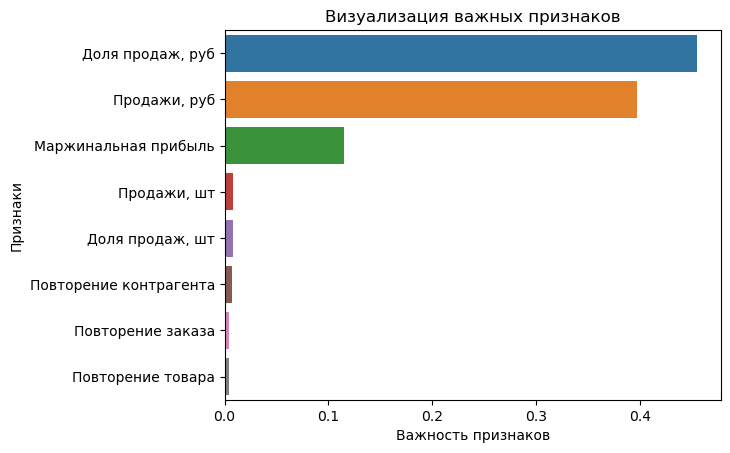

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()

Оставим только первые три признака

In [120]:
df_prepared_temp = df_prepared[['Продажи, руб', 'Доля продаж, руб', 'Маржинальная прибыль', 'ABC']]
y = df_prepared_temp['ABC']
X = df_prepared_temp.loc[:, df_prepared_temp.columns !='ABC']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [121]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       127
           B       1.00      1.00      1.00       139
           C       1.00      1.00      1.00       293

    accuracy                           1.00       559
   macro avg       1.00      1.00      1.00       559
weighted avg       1.00      1.00      1.00       559



2. Логистическая регрессия

In [123]:
from sklearn.linear_model import LogisticRegression



In [124]:
y = df_prepared['ABC']
X = df_prepared.loc[:, df_prepared.columns !='ABC']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

clf=LogisticRegression(multi_class='multinomial');

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.8211091234347049
              precision    recall  f1-score   support

           A       0.79      0.86      0.82       125
           B       0.67      0.64      0.65       145
           C       0.91      0.90      0.90       289

    accuracy                           0.82       559
   macro avg       0.79      0.80      0.79       559
weighted avg       0.82      0.82      0.82       559



3. KNN

In [125]:
from sklearn.neighbors import KNeighborsClassifier

In [126]:
y = df_prepared['ABC']
X = df_prepared.loc[:, df_prepared.columns !='ABC']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

clf=KNeighborsClassifier();

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.9892665474060823
              precision    recall  f1-score   support

           A       1.00      0.97      0.98       125
           B       0.97      0.99      0.98       145
           C       1.00      1.00      1.00       289

    accuracy                           0.99       559
   macro avg       0.99      0.99      0.99       559
weighted avg       0.99      0.99      0.99       559



C:\Users\baidukov\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Вывод 
Ансамблевый метод показал себя очень хорошо, высокая точность обеспечивается за счет как использования ансамблевого решения